In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display as ipd
from glob import glob
import librosa
import seaborn as sns
import librosa.display
import skimage.io
import glob

In [2]:
DATA_PATH = "./data/"
PROCESSED_TRAIN_DATA_PATH = "./data/processed_train_aug/"
PROCESSED_TEST_DATA_PATH = "./data/processed_test_aug/"
# Number of mel specs to create for each audio using random clipping and audio transforms
NUM_MEL_SPECS = 5

class AudioConfig:
    # settings
    # number of samples per time-step in spectrogram. Defaults to win_length / 4
    # Also the step or stride between windows. If the step is smaller than the window length, the windows will overlap
    hop_length = 512 
    # number of bins in spectrogram. Height of image
    n_mels = 224 
    # number of time-steps. Width of image
    time_steps = 512 
    # number of samples per second
    sampling_rate = 44100
    # sec
    duration = 5 
    fmin = 20
    fmax = sampling_rate // 2
    # FFT window size or length of the windowed signal after padding with zeros. Default value = 2048 ( for music signals)    
    n_fft = hop_length * 4
    # Each frame of audio is windowed by window of length win_length and then padded with zeros to match n_fft. Defaults to n_fft
    win_length = hop_length * 4    
    padmode = 'constant'
    samples = sampling_rate * duration

In [3]:
df_train = pd.read_csv(DATA_PATH + "train.csv")
df_train["file_exists"] = df_train.filepath.map(lambda fp: os.path.exists(DATA_PATH + fp))
df_train.head()

,song_id,filename,filepath,genre_id,genre,file_exists
0,10150,010150.ogg,train/010150.ogg,7,Instrumental,True
1,7358,007358.ogg,train/007358.ogg,2,Punk,True
2,20573,020573.ogg,train/020573.ogg,5,Folk,True
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic,True
4,16662,016662.ogg,train/016662.ogg,1,Rock,True


In [4]:
df_train[~df_train.file_exists]

,song_id,filename,filepath,genre_id,genre,file_exists
1359,3137,003137.ogg,train/003137.ogg,1,Rock,False
4668,11088,011088.ogg,train/011088.ogg,2,Punk,False
5150,16312,016312.ogg,train/016312.ogg,7,Instrumental,False
8764,24899,024899.ogg,train/024899.ogg,0,Electronic,False
10155,4040,004040.ogg,train/004040.ogg,4,Hip-Hop,False
10873,9963,009963.ogg,train/009963.ogg,3,Experimental,False
11386,15980,015980.ogg,train/015980.ogg,4,Hip-Hop,False
11497,22698,022698.ogg,train/022698.ogg,4,Hip-Hop,False
14377,23078,023078.ogg,train/023078.ogg,5,Folk,False
14827,17940,017940.ogg,train/017940.ogg,0,Electronic,False


In [5]:
df_test = pd.read_csv(DATA_PATH + "test.csv")
df_test["file_exists"] = df_test.filepath.map(lambda fp: os.path.exists(DATA_PATH + fp))
df_test.head()

,song_id,filename,filepath,file_exists
0,7072,007072.ogg,test/007072.ogg,True
1,10207,010207.ogg,test/010207.ogg,True
2,20008,020008.ogg,test/020008.ogg,True
3,10924,010924.ogg,test/010924.ogg,True
4,21896,021896.ogg,test/021896.ogg,True


In [30]:
df_train_grouped = df_train.groupby(["genre"])
df_genre_song_count = df_train_grouped[["song_id"]].count().sort_values(by=["song_id"], ascending=False)
df_genre_song_count["genre_ratio"] = df_genre_song_count.song_id.apply(lambda genre_count: genre_count/df_genre_song_count.song_id.sum())
df_genre_song_count = df_genre_song_count.rename(columns={"song_id": "song_count"})
df_genre_song_count

,song_count,genre_ratio
genre,,
Rock,3097,0.155456
Electronic,3073,0.154252
Punk,2584,0.129706
Experimental,1801,0.090403
Hip-Hop,1761,0.088395
Folk,1215,0.060988
Chiptune / Glitch,1181,0.059281
Instrumental,1045,0.052455
Pop,945,0.047435


In [173]:
def crop_or_pad(y, length, is_train=True):
    """
    Crops an array to a chosen length
    Arguments:
        y {1D np array} -- Array to crop
        length {int} -- Length of the crop
        sr {int} -- Sampling rate
    Keyword Arguments:
        train {bool} -- Whether we are at train time. If so, crop randomly, else return the beginning of y (default: {True})        
    Returns:
        1D np array -- Cropped array
    """
    # # trim silence
    # if len(y) > 0:
    #     # trim, top_db=default(60) (Below 60dB is considered silence)
    #     y, _ = librosa.effects.trim(y)
    if length > len(y):
        # if length of array is less than the length to be cropped, we need to pad 
        padding = length - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, padding - offset), AudioConfig.padmode)
    else:
        if not is_train:
            start = 0
        else:
            start = np.random.randint(len(y) - length)            
        y = y[start: start + length]
    return y.astype(np.float32)        

In [174]:
import soundfile

def read_audio(audio_path, is_train=True, is_crop_or_pad=True):    
    y, sr = soundfile.read(audio_path)
    if len(y.shape) > 1:
        y = np.mean(y, axis=1)    
    #y, sr = librosa.load(audio_path, sr=AudioConfig.sampling_rate, res_type="kaiser_fast")        
    if is_crop_or_pad:
        audio_samples_length = AudioConfig.sampling_rate * AudioConfig.duration
        y = crop_or_pad(y, audio_samples_length, is_train=is_train)
    return (y, sr)

In [175]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """
    Converts a one channel array to a 3 channel one in [0, 255]
    Arguments:
        X {numpy array [H x W]} -- 2D array to convert
    Keyword Arguments:
        eps {float} -- To avoid dividing by 0 (default: {1e-6})
        mean {None or np array} -- Mean for normalization (default: {None})
        std {None or np array} -- Std for normalization (default: {None})
    Returns:
        numpy array [3 x H x W] -- RGB numpy array
    """
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

In [176]:
def create_mel_spec(y, sr, conf):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        sr {int} -- audio sample rate
        conf {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, n_fft, hop_length
    Returns:
        np array -- Mel-spectrogram
    """
    mel_s = librosa.feature.melspectrogram(
        y=y, 
        sr=sr, 
        n_mels=conf.n_mels,
        n_fft=conf.n_fft, 
        hop_length=conf.hop_length,
        fmin=conf.fmin,
        fmax=conf.fmax
    )
    # convert amplitude to decibels
    mel_s = librosa.power_to_db(mel_s, ref=np.max)            
    return mel_s 

In [179]:
def show_spectrogram(spec, title, sr, hop_length, y_axis='log', x_axis='time'):
    librosa.display.specshow(spec, sr=sr, y_axis=y_axis, x_axis=x_axis, hop_length=hop_length)
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

In [180]:
from soundfile import SoundFile

def get_audio_info(filepath):
    """Get some properties from  an audio file"""
    with SoundFile(filepath) as f:
        sr = f.samplerate
        frames = f.frames
        duration = float(frames)/sr
    return {"frames": frames, "sr": sr, "duration": duration}

result = get_audio_info("./data/train/000004.ogg")
result

{'frames': 1323119, 'sr': 44100, 'duration': 30.00269841269841}

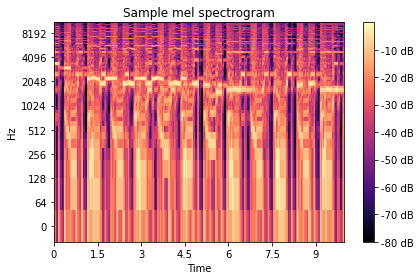

In [181]:
# test by generating and displaying some mel spectrograms
audio_path = "./data/train/000002.ogg"
y, sr = read_audio(audio_path)    
sample_mels = create_mel_spec(y, sr, AudioConfig)
show_spectrogram(sample_mels, "Sample mel spectrogram", sr=AudioConfig.sampling_rate, hop_length=AudioConfig.hop_length)

In [182]:
sample_mels = mono_to_color(sample_mels)
skimage.io.imsave("000002_1.jpg", sample_mels)

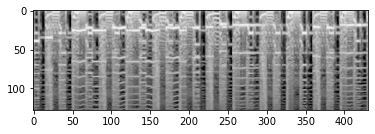

In [183]:
from PIL import Image
img = Image.open("000002_1.jpg")
plt.imshow(img)

In [184]:
img_arr = np.array(img)
img_arr.shape

(128, 431, 3)

In [185]:
import os

def create_processing_dirs():
    if not os.path.isdir(PROCESSED_TRAIN_DATA_PATH):
        os.mkdir(PROCESSED_TRAIN_DATA_PATH)
    if not os.path.isdir(PROCESSED_TEST_DATA_PATH):
        os.mkdir(PROCESSED_TEST_DATA_PATH)            

In [186]:
import audiomentations
from audiomentations import AddGaussianSNR, TimeStretch, PitchShift, Shift

audio_transforms = audiomentations.Compose([
    AddGaussianSNR(min_snr_in_db=5, max_snr_in_db=40.0, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

def apply_audio_transforms(y, sr):        
    y = audio_transforms(samples=y, sample_rate=sr)        
    return y

In [187]:
def audio_to_melspec(file_path, folder_path):
    filename_no_ext = file_path.split("/")[-1].split(".")[0]
    file_path = DATA_PATH + file_path    
    if os.path.exists(file_path):
        for i in range(NUM_MEL_SPECS):            
            y, sr = read_audio(file_path)
            y = apply_audio_transforms(y, sr)
            mel_s = create_mel_spec(y, sr, AudioConfig)
            mel_s = mono_to_color(mel_s)        
            if not os.path.isdir(folder_path + "mel_spec/"):
                os.mkdir(folder_path + "mel_spec/")
            mel_s_img_name = filename_no_ext + f"_{i}.jpg"                
            mels_img_path = folder_path + "mel_spec/" + mel_s_img_name       
            # save as PNG
            skimage.io.imsave(mels_img_path, mel_s)            
    return file_path

In [188]:
from tqdm.notebook import tqdm
from joblib import delayed, Parallel

create_processing_dirs()
delayed_funcs_train = [delayed(audio_to_melspec)(row["filepath"], PROCESSED_TRAIN_DATA_PATH) 
                       for i, row in df_train[df_train.file_exists].iterrows()]
results_train = Parallel(n_jobs=-1, verbose=5)(delayed_funcs_train)    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | ela

In [189]:
# for each audio we have generated NUM_MEL_SPECS mel spec images
# we create a new df_aug from df_train or df_test containing info of generated mel spectrograms
def aug_df(df, mel_spec_dir):
    df_mels = []    
    for i, row in df[df.file_exists].iterrows():
        filename_noext = row["filename"].split(".")[0]    
        for mels_path in glob.glob(mel_spec_dir + filename_noext + "*"):
            song_row = df[df.song_id == row["song_id"]].copy(deep=True)
            mels_img_name = mels_path.split("/")[-1]
            song_row["mel_spec"] = mels_img_name
            df_mels.append(song_row)
    df_aug = pd.concat(df_mels, axis=0)
    df_aug = df_aug.reset_index(drop=True)
    return df_aug

In [190]:
df_train_aug = aug_df(df_train, PROCESSED_TRAIN_DATA_PATH + "mel_spec/")    
df_train_aug.to_csv(DATA_PATH + "df_train_aug.csv")

In [191]:
delayed_funcs_test = [delayed(audio_to_melspec)(row["filepath"], PROCESSED_TEST_DATA_PATH) 
                      for i, row in df_test[df_test.file_exists].iterrows()]
results_test = Parallel(n_jobs=-1, verbose=5)(delayed_funcs_test)    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 14.4min
/tmp/ipykernel_561/419396354.py:15: UserWarning: ./data/processed_test_aug/mel_spec/001116_0.jpg is a low contra

In [192]:
df_test_aug = aug_df(df_test, PROCESSED_TEST_DATA_PATH + "mel_spec/")    
df_test_aug.to_csv(DATA_PATH + "df_test_aug.csv")

In [193]:
# zip the processed_train and processed_test folders
!zip -rq mel_spec_train.zip ./data/processed_train_aug/mel_spec
!zip -rq mel_spec_test.zip ./data/processed_test_aug/mel_spec

/bin/bash: zip: command not found
/bin/bash: zip: command not found
